In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('PSCompPars_data.csv')
df2 = pd.read_csv('webscraped_data.csv')

In [3]:
merged_df = pd.merge(df, df2[['pl_name', 'pl_fullname', 'pl_type']], on='pl_name', how='left')

# weird 6 rows don't have a mapping even though they still show in NASA Exoplanet Archive
merged_df = merged_df.dropna(subset=['pl_type']).reset_index(drop=True)

planet_types = {'Gas Giants':'Gas Giant',
                'Neptune-likes':'Neptune-like',
                'Super Earths':'Super-Earth',
                'Terrestrials':'Terrestrial',
                'Unknowns':'Unknown'}
merged_df['pl_type'] = merged_df['pl_type'].replace(planet_types)

In [4]:
merged_df.head(5)

,pl_name,disc_method,pl_controv_flag,pl_orbper_days,pl_radius_earth,pl_mass_earth,pl_eccentricity,pl_equil_tp,st_teff,st_radius,st_mass,st_acc,Ks_brightness,pl_fullname,pl_type
0,11 Com b,Radial Velocity,0,323.21000,12.2,4914.89849,0.238,NaN,4874.0,13.76,2.09,2.45,2.282,11 Comae Berenices b,Gas Giant
1,11 UMi b,Radial Velocity,0,516.21997,12.3,4684.81420,0.080,NaN,4213.0,29.79,2.78,1.93,1.939,11 Ursae Minoris b,Gas Giant
2,14 And b,Radial Velocity,0,186.76000,13.1,1131.15130,0.000,NaN,4888.0,11.55,1.78,2.55,2.331,14 Andromedae b,Gas Giant
3,14 Her b,Radial Velocity,0,1765.03890,12.6,2559.47216,0.373,NaN,5338.0,0.93,0.91,4.45,4.714,14 Herculis b,Gas Giant
4,16 Cyg B b,Radial Velocity,0,798.50000,13.5,565.73740,0.680,NaN,5750.0,1.13,1.08,4.36,4.651,16 Cygni B b,Gas Giant


In [5]:
# replacing NaNs with average mass and radius of the respective planet type group to use these features for KNN
mean_mass_by_type = merged_df.groupby('pl_type')['pl_mass_earth'].transform('mean')
merged_df['pl_mass_earth'] = merged_df['pl_mass_earth'].fillna(mean_mass_by_type)
mean_radius_by_type = merged_df.groupby('pl_type')['pl_radius_earth'].transform('mean')
merged_df['pl_radius_earth'] = merged_df['pl_radius_earth'].fillna(mean_radius_by_type)

print(merged_df['pl_mass_earth'].isna().sum())
print(merged_df['pl_radius_earth'].isna().sum())

6
6


In [6]:
# these correspond to the 6 Unknown planet type exoplanets
dropped_rows = merged_df[merged_df['pl_radius_earth'].isna()]

In [7]:
merged_df = merged_df.dropna(subset=['pl_radius_earth'])

In [8]:
features = ['pl_mass_earth', 'pl_radius_earth']

# to use KNN to correct mislabeled data for planets where URL went to the Milky Way and recorded planet type as SPACE
X_train = merged_df[merged_df['pl_type'] != 'SPACE'][features]
y_train = merged_df[merged_df['pl_type'] != 'SPACE']['pl_type']
X_test = merged_df[merged_df['pl_type'] == 'SPACE'][features]

In [9]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

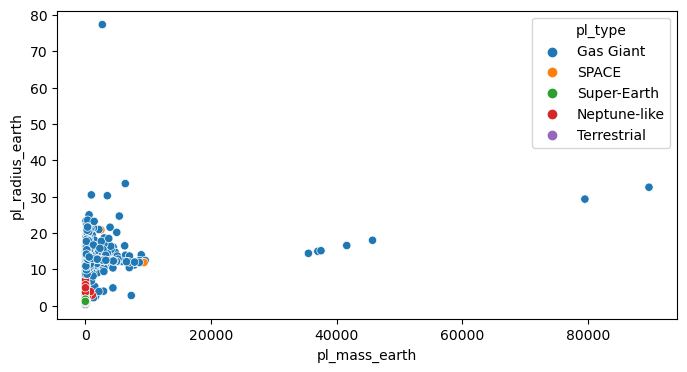

In [10]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x='pl_mass_earth', y='pl_radius_earth', hue='pl_type', data=merged_df, palette='tab10')
plt.show()

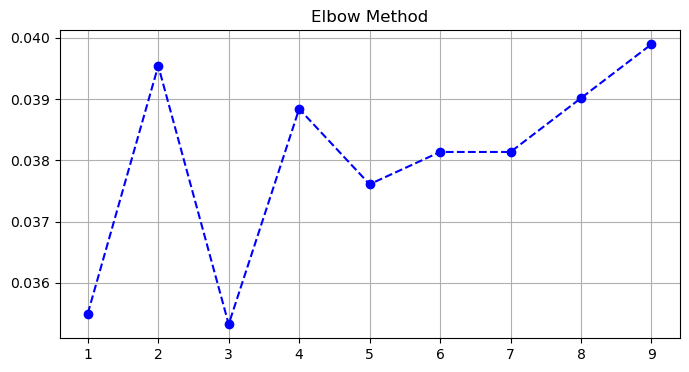

In [11]:
error_rates = []
k_values = range(1, 10)
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
    error_rates.append(1 - scores.mean())  # Store error (1 - accuracy)

plt.figure(figsize=(8, 4))
plt.plot(k_values, error_rates, marker='o', linestyle='--', color='b')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

In [12]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

predicted_labels = knn.predict(X_test_scaled)

merged_df.loc[merged_df['pl_type'] == 'SPACE', 'pl_type'] = predicted_labels

In [13]:
# data for Mash for table display
# data = pd.concat([merged_df, dropped_rows], ignore_index=True)
# data = data[['pl_name', 'pl_fullname', 'pl_type']].reset_index(drop=True)
# data.to_csv('clean_labeled_data.csv')